## Data preparation

In [1]:
import cv2
import os
import numpy as np
import glob
import csv
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import gast

import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

BASE_PATH = 'GTSRB/Final_Training/Images'
TEST_PATH = 'GTSRB/Final_Test'
np.random.seed(1)

/home/tymek/programs/python/ripo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tymek/programs/python/ripo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tymek/programs/python/ripo/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tymek/programs/python/ripo/venv

## Functions

In [2]:
def resize():
    counter = 0
    for dirname in os.listdir(BASE_PATH):
        for filename in os.listdir(os.path.join(BASE_PATH, dirname)):
            if filename.endswith(".ppm"):
                image_path = os.path.join(BASE_PATH, dirname, filename)
                im = cv2.imread(image_path)
                resized_im = cv2.resize(im, (32, 32))
                cv2.imwrite(image_path, resized_im)

In [3]:
def sanity_check():
    counter = 0
    for dirname in os.listdir(BASE_PATH):
        for filename in os.listdir(os.path.join(BASE_PATH, dirname)):
            if filename.endswith(".ppm"):
                image_path = os.path.join(BASE_PATH, dirname, filename)
                im = cv2.imread(image_path)
                if im.shape != (32, 32, 3):
                    counter += 1
    print(counter)

In [4]:
def load_dataset():
    filelist = glob.glob(f'{BASE_PATH}/*/*.ppm')
    testlist = glob.glob(f'{TEST_PATH}/Images/*.ppm')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )
    X_test = np.array([np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist])

    Y_train = np.array([np.zeros(43) for fname in filelist])
    for i,fname in enumerate(filelist):
        Y_train[i][int(fname.split('/')[3])]=1

    with open(f'{TEST_PATH}/GT-final_test.csv') as csvfile:
        spamreader = csv.reader(csvfile,delimiter=';')
        data = list(spamreader)
        data.pop(0)

    Y_test = np.array([np.zeros(43) for fname in testlist])
    for i,fname in enumerate(testlist):
        image_name = fname.split('/')[3]
        image_number = int(image_name.split('.')[0])
        classid = int(data[image_number][7])
        Y_test[i][classid]=1

    return X_train, Y_train, X_test, Y_test

In [5]:
def show_image(index, X, Y):
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    print('Belongs to class nr: ' + str(int(np.where(Y[index]==1)[0])))

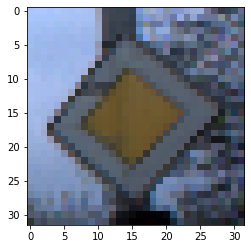

Belongs to class nr: 5


In [6]:
X_train, Y_train, X_test, Y_test = load_dataset()
show_image(random.randint(0,12629),X_test, Y_test)

## Deep learning functions and its tests

In [7]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype='float')
    Y = tf.placeholder(shape=[None, n_y], dtype='float')
    return X, Y

In [8]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


In [9]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [10]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(parameters["W1"].eval()[1,1,1]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(parameters["W2"].eval()[1,1,1]))
    print("W2.shape: " + str(parameters["W2"].shape))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1[1,1,1] = 
[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)


In [15]:
# GRADED FUNCTION: forward_propagation

# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn=None)

    return Z3

In [16]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))

Z3 = 
[[ 1.4416982  -0.24909668  5.4504995  -0.2618962  -0.20669872  1.3654671 ]
 [ 1.4070847  -0.02573182  5.08928    -0.4866991  -0.4094069   1.2624853 ]]


In [13]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [14]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 4.6648703
